In [95]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size = 100
learning_rate = 0.001
epoch=100

cifar_train = dset.CIFAR10('CIFAR10/',train=True,transform=transforms.Compose([
    # transforms.Scale(36),
    # transforms.CenterCrop(32),
    # transforms.RandomHorizontalFlip(),
    # transforms.Lambda(lambda x: x.rotate(90)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
    ])
    ,target_transform=None, download=True)
cifar_test  = dset.CIFAR10('CIFAR10/',train=False,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))
    ]),target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
cifar_train 길이: 50000
cifiar_test 길이: 10000
image data 형태: torch.Size([3, 32, 32])
label:  9


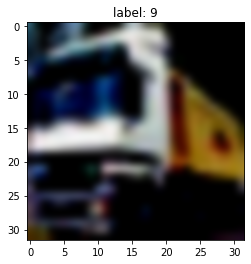

In [96]:
print('cifar_train 길이:',len(cifar_train))
print('cifiar_test 길이:',len(cifar_test))

image, label = cifar_train.__getitem__(1)
print('image data 형태:',image.size())
print('label: ',label)

r,g,b=image[0,:,:],image[1,:,:],image[2:,:,:]
img = np.zeros((image.shape[1],image.shape[2],image.shape[0]))
img[:,:,0],img[:,:,1],img[:,:,2] = r,g,b

plt.title('label: %d' %label)
plt.imshow(img,interpolation='bicubic')
plt.show()

In [97]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0

    for i, (imgs, labels) in enumerate(dloader):
        img = Variable(imgs,requires_grad=True).cuda()
        label = Variable(labels).cuda()

        output = imodel.forward(img)
        _, output_index = torch.max(output,1)

        total+=label.size(0)
        correct+=(output_index==label).sum().float()

    print('Accuracy of Test Data: {}'.format(100*correct/total))

In [98]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:],batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test,batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(4096, 100),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.BatchNorm1d(100),
            nn.Linear(100,10)
        )

        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data) #He initialization
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)

    def forward(self,x):
        insize=x.size(0)
        out = self.layer(x)
        out=out.view(insize,-1)
        out=self.fc_layer(out)
    
        return out

model = CNN().cuda()

epoch: 0 Loss: 1.670
Accuracy of Test Data: 55.37999725341797
epoch: 1 Loss: 1.269
Accuracy of Test Data: 62.91999816894531
epoch: 2 Loss: 0.965
Accuracy of Test Data: 66.8699951171875
epoch: 3 Loss: 1.128
Accuracy of Test Data: 68.97000122070312
epoch: 4 Loss: 1.197
Accuracy of Test Data: 70.18000030517578
epoch: 5 Loss: 0.942
Accuracy of Test Data: 71.63999938964844
epoch: 6 Loss: 0.915
Accuracy of Test Data: 73.0999984741211
epoch: 7 Loss: 0.859
Accuracy of Test Data: 73.33999633789062
epoch: 8 Loss: 0.790
Accuracy of Test Data: 74.1500015258789
epoch: 9 Loss: 0.661
Accuracy of Test Data: 74.54999542236328
epoch: 10 Loss: 0.599
Accuracy of Test Data: 74.54999542236328
epoch: 11 Loss: 0.677
Accuracy of Test Data: 74.63999938964844
epoch: 12 Loss: 0.674
Accuracy of Test Data: 74.81999969482422
epoch: 13 Loss: 0.664
Accuracy of Test Data: 74.97000122070312
epoch: 14 Loss: 0.697
Accuracy of Test Data: 74.62999725341797
epoch: 15 Loss: 0.724
Accuracy of Test Data: 74.95999908447266
epoch

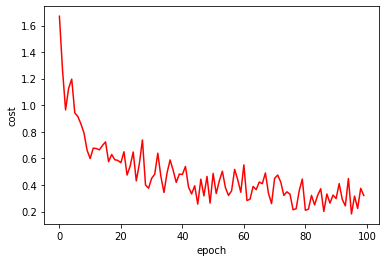

In [99]:
loss_func = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
X = []
y = []
for i in range(epoch):
    loss=0.0
    model.train()
    for j, (img,label) in enumerate(train_loader):
        x=Variable(img).cuda()
        y_=Variable(label).cuda()
        optimizer.zero_grad()
        output = model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
    
    print(f'epoch: {i} Loss: {loss.item():.3f}')
    model.eval()
    ComputeAccr(test_loader,model)       
    y.append(loss.item())
    X.append(i)

plt.plot(X,y,'r-')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.show()

In [88]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data: 75.8699951171875
